## Problem set 10

**Problem 0** (-2 points for every missing green OK sign. If you don't run the cell below, that's -14 points.)

Make sure you are in the DATA1030 environment.

In [1]:
from __future__ import print_function
from packaging.version import parse as Version
from platform import python_version

OK = '\x1b[42m[ OK ]\x1b[0m'
FAIL = "\x1b[41m[FAIL]\x1b[0m"

try:
    import importlib
except ImportError:
    print(FAIL, "Python version 3.10 is required,"
                " but %s is installed." % sys.version)

def import_version(pkg, min_ver, fail_msg=""):
    mod = None
    try:
        mod = importlib.import_module(pkg)
        if pkg in {'PIL'}:
            ver = mod.VERSION
        else:
            ver = mod.__version__
        if Version(ver) == Version(min_ver):
            print(OK, "%s version %s is installed."
                  % (lib, min_ver))
        else:
            print(FAIL, "%s version %s is required, but %s installed."
                  % (lib, min_ver, ver))    
    except ImportError:
        print(FAIL, '%s not installed. %s' % (pkg, fail_msg))
    return mod


# first check the python version
pyversion = Version(python_version())

if pyversion >= Version("3.10"):
    print(OK, "Python version is %s" % pyversion)
elif pyversion < Version("3.10"):
    print(FAIL, "Python version 3.10 is required,"
                " but %s is installed." % pyversion)
else:
    print(FAIL, "Unknown Python version: %s" % pyversion)

    
print()
requirements = {'numpy': "1.22.4", 'matplotlib': "3.5.2",'sklearn': "1.1.1", 
                'pandas': "1.4.2",'xgboost': "1.5.1", 'shap': "0.40.0"}

# now the dependencies
for lib, required_version in list(requirements.items()):
    import_version(lib, required_version)

[ OK ] Python version is 3.10.5

[ OK ] numpy version 1.22.4 is installed.
[ OK ] matplotlib version 3.5.2 is installed.
[ OK ] sklearn version 1.1.1 is installed.
[ OK ] pandas version 1.4.2 is installed.
[FAIL] xgboost version 1.5.1 is required, but 1.5.0 installed.


/Users/henryjiang/opt/anaconda3/envs/data1030/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


[ OK ] shap version 0.40.0 is installed.


You will work with the kaggle house price dataset in this problem set and work through a couple of different feature importance metrics. We provide code to train an XGBoost regression model to start you off. 

The main take-away from this problem set is that feature importance is not easy to measure and it depends strongly on what metric you use. 

In [2]:
# read the data
import pandas as pd
import numpy  as np
from sklearn.model_selection import train_test_split
from collections import Counter
import warnings
warnings.filterwarnings("ignore")

# Let's load the data
df = pd.read_csv('data/train.csv')
# drop the ID
df.drop(columns=['Id'],inplace=True)

# the target variable
y = df['SalePrice']
print(y.shape)
df.drop(columns=['SalePrice'],inplace=True)
# the unprocessed feature matrix
X = df.values
print(X.shape)
# the feature names
ftrs = df.columns

(1460,)
(1460, 79)


In [3]:
# let's split to train, CV, and test
X_other, X_test, y_other, y_test = train_test_split(df, y, test_size=0.2, random_state=0)
X_train, X_CV, y_train, y_CV = train_test_split(X_other, y_other, test_size=0.25, random_state=0)

print(X_train.shape)
print(X_CV.shape)
print(X_test.shape)

(876, 79)
(292, 79)
(292, 79)


In [4]:
# collect the various features
cat_ftrs = ['MSZoning','Street','Alley','LandContour','LotConfig','Neighborhood','Condition1','Condition2',\
            'BldgType','HouseStyle','RoofStyle','RoofMatl','Exterior1st','Exterior2nd','MasVnrType','Foundation',\
           'Heating','CentralAir','Electrical','GarageType','PavedDrive','MiscFeature','SaleType','SaleCondition']
ordinal_ftrs = ['LotShape','Utilities','LandSlope','ExterQual','ExterCond','BsmtQual','BsmtCond','BsmtExposure',\
               'BsmtFinType1','BsmtFinType2','HeatingQC','KitchenQual','Functional','FireplaceQu','GarageFinish',\
               'GarageQual','GarageCond','PoolQC','Fence']
ordinal_cats = [['Reg','IR1','IR2','IR3'],['AllPub','NoSewr','NoSeWa','ELO'],['Gtl','Mod','Sev'],\
               ['Po','Fa','TA','Gd','Ex'],['Po','Fa','TA','Gd','Ex'],['NA','Po','Fa','TA','Gd','Ex'],\
               ['NA','Po','Fa','TA','Gd','Ex'],['NA','No','Mn','Av','Gd'],['NA','Unf','LwQ','Rec','BLQ','ALQ','GLQ'],\
               ['NA','Unf','LwQ','Rec','BLQ','ALQ','GLQ'],['Po','Fa','TA','Gd','Ex'],['Po','Fa','TA','Gd','Ex'],\
               ['Sal','Sev','Maj2','Maj1','Mod','Min2','Min1','Typ'],['NA','Po','Fa','TA','Gd','Ex'],\
               ['NA','Unf','RFn','Fin'],['NA','Po','Fa','TA','Gd','Ex'],['NA','Po','Fa','TA','Gd','Ex'],
               ['NA','Fa','TA','Gd','Ex'],['NA','MnWw','GdWo','MnPrv','GdPrv']]
num_ftrs = ['MSSubClass','LotFrontage','LotArea','OverallQual','OverallCond','YearBuilt','YearRemodAdd',\
             'MasVnrArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','1stFlrSF','2ndFlrSF',\
             'LowQualFinSF','GrLivArea','BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','BedroomAbvGr',\
             'KitchenAbvGr','TotRmsAbvGrd','Fireplaces','GarageYrBlt','GarageCars','GarageArea','WoodDeckSF',\
             'OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea','MiscVal','MoSold','YrSold']

In [5]:
# preprocess with pipeline and columntransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# one-hot encoder
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant',fill_value='missing')),
    ('onehot', OneHotEncoder(sparse=False,handle_unknown='ignore'))])

# ordinal encoder
ordinal_transformer = Pipeline(steps=[
    ('imputer2', SimpleImputer(strategy='constant',fill_value='NA')),
    ('ordinal', OrdinalEncoder(categories = ordinal_cats))])

# standard scaler
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

# collect the transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_ftrs),
        ('cat', categorical_transformer, cat_ftrs),
        ('ord', ordinal_transformer, ordinal_ftrs)])

In [6]:
# fit_transform the training set
X_prep = preprocessor.fit_transform(X_train)
# little hacky, but collect feature names
feature_names = preprocessor.get_feature_names_out()

df_train = pd.DataFrame(data=X_prep,columns=feature_names)
print(df_train.shape)

# transform the CV
df_CV = preprocessor.transform(X_CV)
df_CV = pd.DataFrame(data=df_CV,columns = feature_names)
print(df_CV.shape)

# transform the test
df_test = preprocessor.transform(X_test)
df_test = pd.DataFrame(data=df_test,columns = feature_names)
print(df_test.shape)

(876, 221)
(292, 221)
(292, 221)


In [7]:
# train the XGBoost model
import xgboost
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

param_grid = {"learning_rate": [0.03],
              "n_estimators": [10000],
              "seed": [0],
              "missing": [np.nan], 
              "colsample_bytree": [0.9],              
              "subsample": [0.66]}

XGB = xgboost.XGBRegressor()
XGB.set_params(**ParameterGrid(param_grid)[0])
XGB.fit(df_train,y_train,early_stopping_rounds=50,eval_set=[(df_CV, y_CV)], verbose=False)
y_CV_pred = XGB.predict(df_CV)
print('the CV RMSE:',np.sqrt(mean_squared_error(y_CV,y_CV_pred)))
y_test_pred = XGB.predict(df_test)
print('the test RMSE:',np.sqrt(mean_squared_error(y_test,y_test_pred)))
print('the test R2:',r2_score(y_test,y_test_pred))

the CV RMSE: 23470.132687324658
the test RMSE: 31748.96283078089
the test R2: 0.8540372805542484


**Problem 1** (5 points)

Calculate the perturbation feature importance values on the test set and visualize the results. This dataset has many features so show only the top 10 most important ones on the figure. You can use the code from the lecture notes or work with sklearn's [permutation_importance](https://scikit-learn.org/stable/modules/generated/sklearn.inspection.permutation_importance.html).

/Users/henryjiang/opt/anaconda3/envs/data1030/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/henryjiang/opt/anaconda3/envs/data1030/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


<AxesSubplot:title={'center':'Top Features'}, ylabel='top_ftrs_name'>

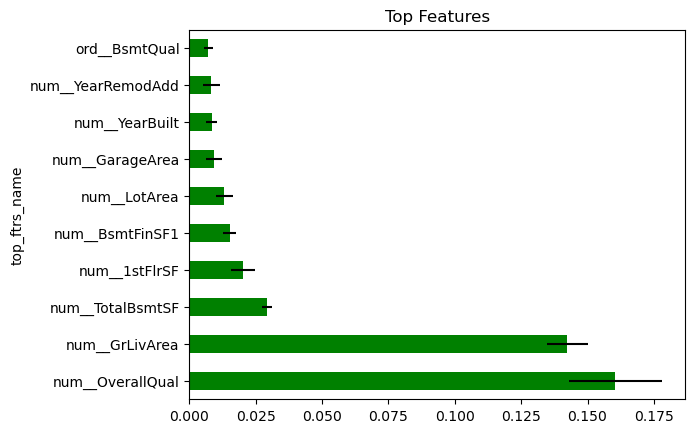

In [8]:

from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

result = permutation_importance(XGB, df_test, y_test, n_repeats=10,
                                random_state=42, n_jobs=2)
idx=result.importances_mean.argsort()[::-1]
idx=idx[0:10]
mean=result.importances_mean
std=result.importances_std
top_mean=[]
top_std=[]
top_ftrs_names=[]
for i in idx:
    top_mean.append(mean[i])
    top_std.append(std[i])
    top_ftrs_names.append(feature_names[i])

ftr_imp_df = pd.DataFrame(
    {'top_ftrs_name': top_ftrs_names,
     'top_mean': top_mean,
     'top_std': top_std
     
    })


ftr_imp_df=ftr_imp_df.set_index('top_ftrs_name')

ftr_imp_df.plot(kind = "barh", y = 'top_mean', legend = False,
          xerr = 'top_std', title = "Top Features", color='green')

In [17]:
# import needed libraries
from sklearn.inspection import permutation_importance
import warnings
warnings.filterwarnings("ignore")
# calculate feature permutation importance
ftr_importance = permutation_importance(XGB, df_test, y_test, scoring='neg_root_mean_squared_error',
n_repeats=10, random_state=2)
# save each feature's importance scores over the 10 trials
importances = ftr_importance.importances

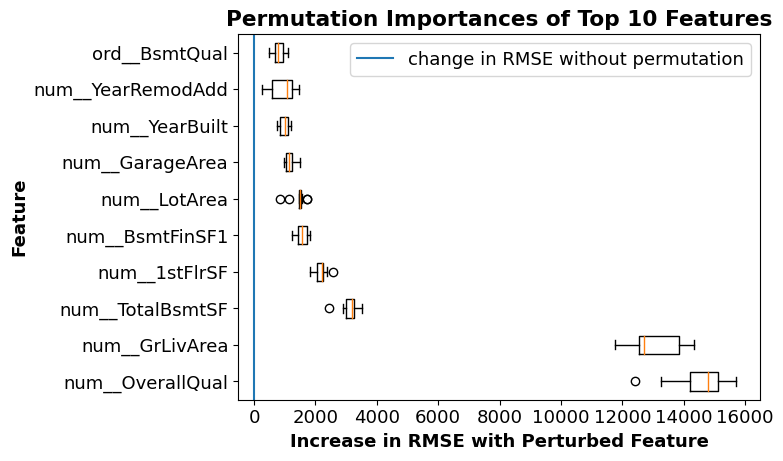

In [18]:
# obtain ordered indexes for ascending importance
ascend_ind = np.argsort(np.mean(importances,axis=1))[::-1]
# plot and show graph
plt.rcParams.update({'font.size': 13})
plt.figure(figsize=(8,4.8))
plt.boxplot(importances[ascend_ind][:10].T,labels=feature_names[ascend_ind][:10],vert=False)
plt.axvline(0,label='change in RMSE without permutation')
plt.title("Permutation Importances of Top 10 Features",weight='bold')
plt.xlabel('Increase in RMSE with Perturbed Feature',weight='bold')
plt.ylabel('Feature',weight='bold')
plt.legend()
plt.tight_layout()
plt.show()

**Problem 2** (10 points)

As we discussed in class, XGBoost implements 5 different metrics to measure feature importance. Calculate all 5 metrics and create 5 figures showing the top 10 most important features for each metric.

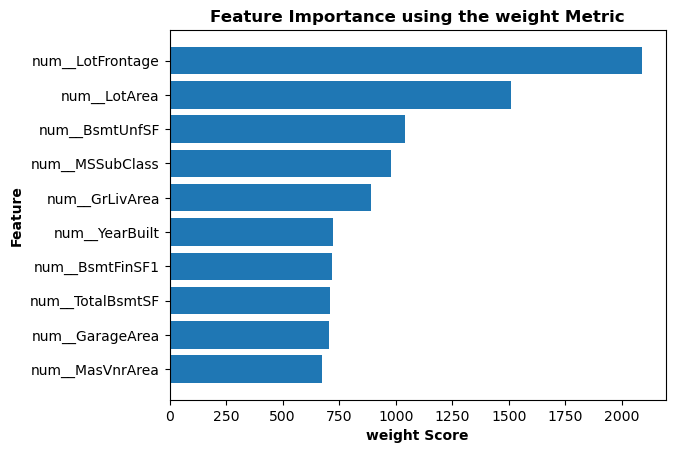

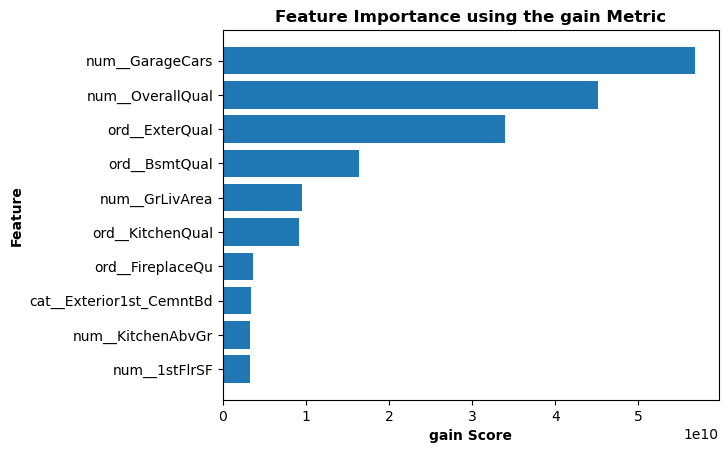

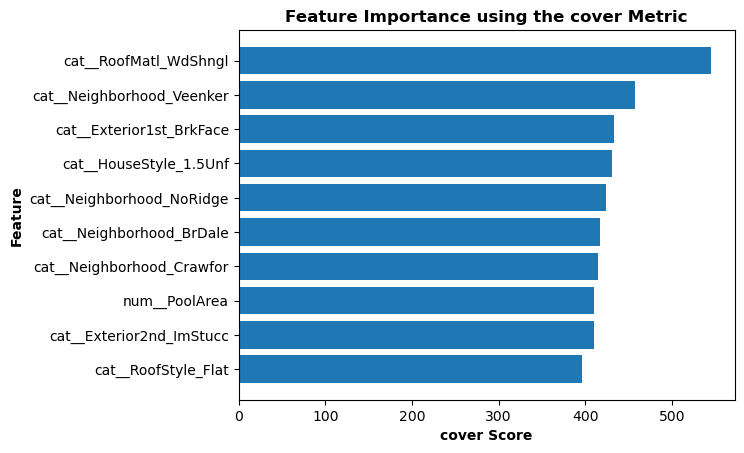

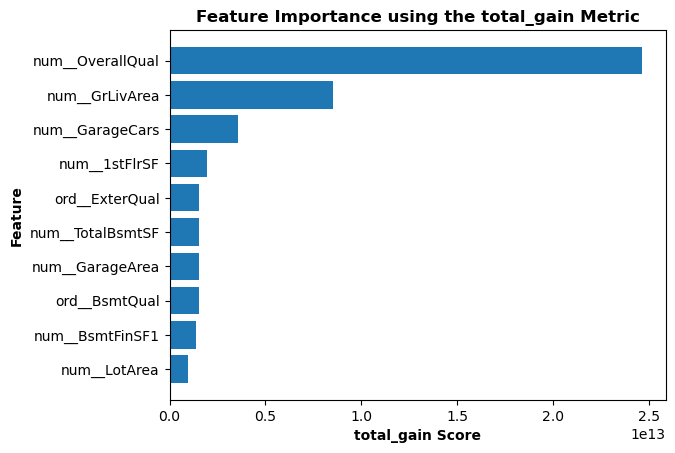

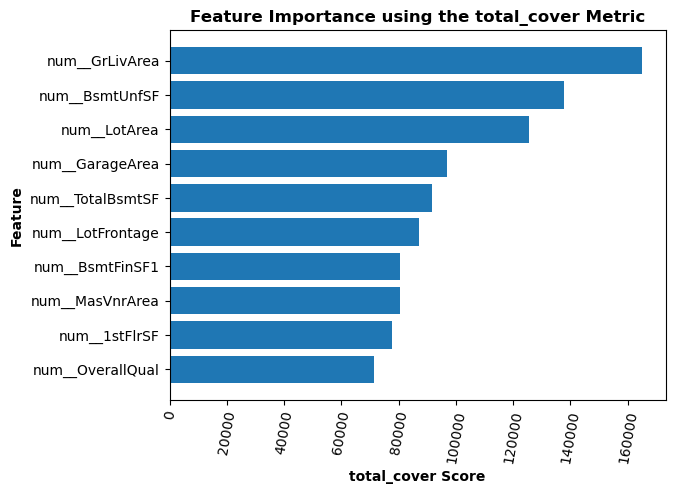

In [9]:
# library to sort dictionary
from collections import Counter
import seaborn as sns
# calculate feature importance measurements for all five metrics
metrics = ['weight','gain','cover','total_gain','total_cover']
results = []
# save importance metrics into master list
for metric in metrics:
    results.append(XGB.get_booster().get_score(fmap="",importance_type=metric))
# plot correct data for each metric
for i, metric in enumerate(results):
    # grab top 10 feature for metric
    c = Counter(metric)
    top10 = c.most_common(10)
    # create and reverse dataframe of info
    mdf = pd.DataFrame(top10).iloc[::-1]
    # create and label plots
    plt.barh(mdf[0],mdf[1])
    # rotate axis for last graph
    if i == 4:
            plt.xticks(rotation=80)
    plt.title('Feature Importance using the {} Metric'.format(metrics[i]),weight='bold')
    plt.ylabel('Feature',weight='bold')
    plt.xlabel('{} Score'.format(metrics[i]),weight='bold')
    plt.show()
        # weight = how many times a feature is used to split
        # gain = average amount of predictive gain from a feature
        # cover = average amount of points that pass through node per tree
        # total_gain = total gain across all trees
        # total_cover = total number of points that pass through feature

**Problem 3a** (10 points)

Let's now calculate the shap values of the test set points. Use the shap values to calculate global feature importance values and prepare a plot that shows the top 10 most important features. Choose one of the two approaches:

1) You can use the shap package as we did in class. You will encounter an error which you'll need to solve yourself. Please do not ask about this error on Ed Discussion. Instead, figure it out yourself. You'll also need to manually change some parameters of the plot.

2) XGBoost can directly calculate shap values for you (look up how) but you need to recreate the figures with matplotlib because XGBoost's shap values don't come with visualizations. 

Both approaches take roughly the same amount of time to work through. 

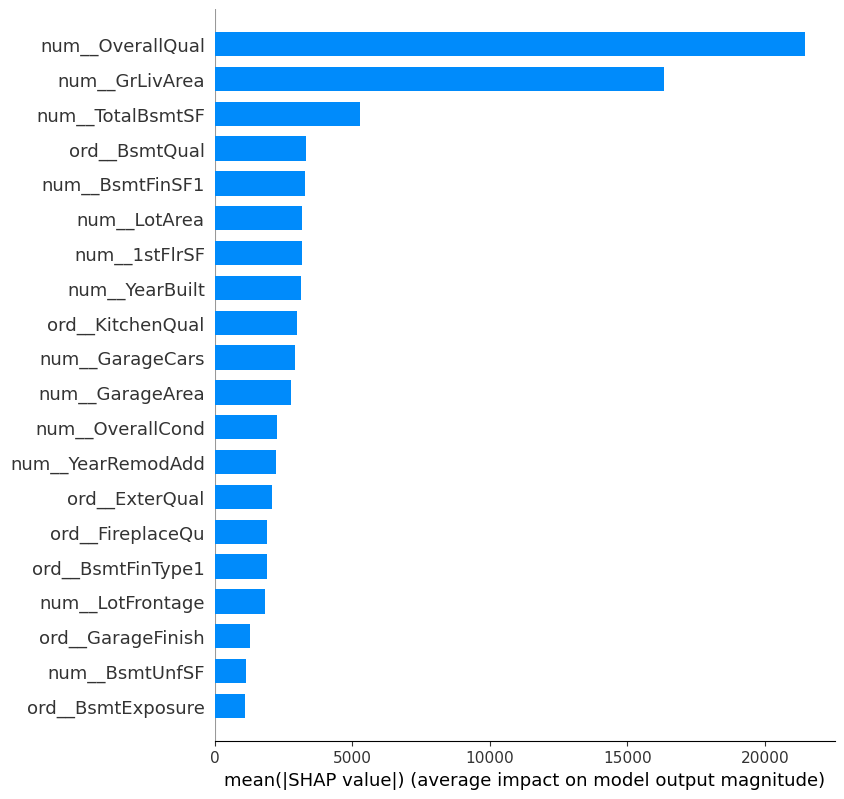

In [10]:
import shap
explainer = shap.TreeExplainer(XGB)
shap_values = explainer.shap_values(df_test)
shap.summary_plot(shap_values,df_test, plot_type="bar")


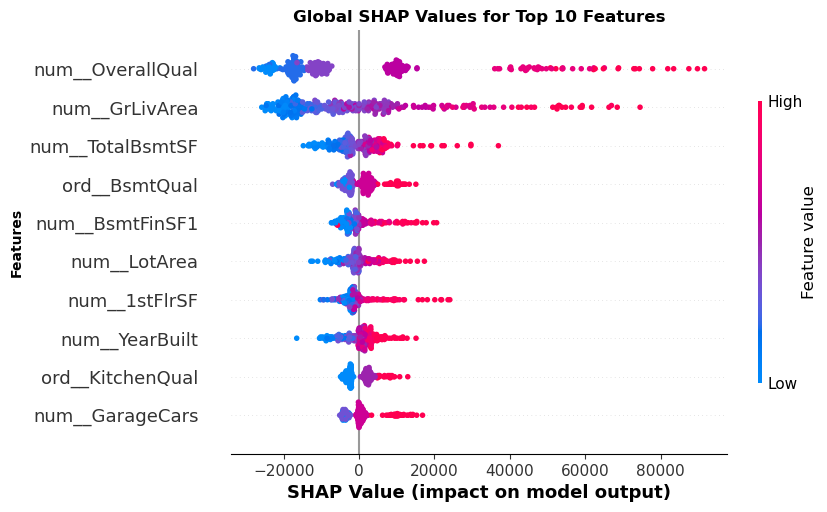

In [11]:
shap.summary_plot(shap_values, df_test,max_display=10,color_bar=True,show=False)
plt.gcf().axes[-1].set_box_aspect(100)
plt.title('Global SHAP Values for Top 10 Features',weight='bold')
plt.ylabel('Features',weight='bold')
plt.xlabel('SHAP Value (impact on model output)',weight='bold')
plt.show()
#global values

**Problem 3b** (10 points)

Let's take a look at some specific data points with indices 0, 100, and 200. For each data point, create a force plot and describe in a paragraph or two which features contribute positively and negatively to the prediction.

In [12]:
import shap
shap.initjs() # required for visualizations later on
# create the explainer object with the random forest model
explainer = shap.TreeExplainer(XGB)
# transform the test set
shap_values = explainer.shap_values(df_test[:])
print(shap_values)


[[ 1.8437952e+02 -1.1399503e+03  1.3589414e+04 ...  6.7253838e+01
  -1.5358219e+00  1.5815424e+02]
 [ 2.4968321e+02  9.5601093e+02 -9.7514575e+02 ...  1.9771477e+02
  -3.6075404e+00 -5.8604156e+02]
 [ 3.4409647e+02  4.6467395e+02 -3.6592170e+03 ...  3.7725497e+02
  -2.9543791e+00  2.1417413e+02]
 ...
 [ 2.4408395e+02 -1.6581382e+03 -4.3306055e+03 ...  9.5482841e+01
  -3.1058726e+00 -6.7308453e+02]
 [-8.9033890e+01 -1.1596489e+03 -4.9510952e+03 ... -1.5019443e+03
  -3.0858881e+00  1.6703043e+02]
 [-3.2149310e+02  3.0594616e+01 -3.1463020e+03 ...  3.0188889e+02
  -1.3301762e+00  1.2570615e+02]]


In [13]:
#create function to return a shap diagram for any index
def shap_by_ind(index):  
    explainerModel = shap.TreeExplainer(XGB)
    shap_values_Model = explainerModel.shap_values(df_test)
    p = shap.force_plot(explainerModel.expected_value, shap_values_Model[index], df_train.iloc[[index]])
    return(p)

In [14]:
shap_by_ind(0)

The size of the living Area pushes the price up. The overall quality pushes the house down. The price of the house is quite high, but the overall quality of the house is only a 6. The model probably lowered the price due to the house not being so nice for an above average house. 

In [15]:
shap_by_ind(100)

There are several features that pushes the price of this house up. There is only one feature that drives it down. The month sold feature says it was sold in January which drives the price of the house down. Demand is usually greater in the summer months. However, after seeing this graph, I would go back and throw month sold out of the model. If we were to predict the price of a house sold, we would not be able to know when it gets sold. A better method would be a variable that takes in the current month and allows the model to adjust the prediction based on the season. The other major features that drives up the house price is quite self explanatory. Overall quality and finished basement are all very important to buyers.

In [16]:
shap_by_ind(200)

This house has a lot of downsides to it which is why the price is low. The house being made of bricks helps boosts its sales price. The overall quality is 5 which is lower than the average of 6 plus. We know that overall quality is a very important feature the model looks at. Living area for the house is also very low at 1339 sqft. This further drives down the price. The size of the house is also a big factor the model looks at. This is why the house is priced at a much lower price than the average.

**Problem 4** (5 points)

You calculated 7 different global feature importance metrics (perturbation, 5 XGB metrics, global shap). Unfortunately the ranked features can be quite different depending on the importance metric used. Write a short discussion on the similarities and differences amongst the 7 methods. Are there features that tend to be in the top 3-5 regardless of the approach used? Discuss the pros and cons of the various approaches!

The first metric perturbation works by shuffling the data. It removes features and sees how well the model performs without certain features. This method is good because it can be used for different models. The issue is sometimes the features interact with each other in ways we can't know. The shuffling would remove potential interaction terms. We could feature engineer permutaion pairs, but most the time it would not be worth it due to how much more computation power that would require.


The next five importance metric we used are specifically related to the XGboost model. These measurements look at nodes and observations that make up each split in the decision tree. For instance, the weight metric rates each feature based on how often it is used to split. The pro of this method is that we have a reliable metric, but it fails to consider feature interactions. Likewise, cover metric looks at the average number of points that pass through each feature node per tree. This metric is useful for understanding how important a feature could be. If a feature is used more, it is more influential. This may be misleading because a decision tree higher up on the tree will see more data. However, the model should take into account of placement, putting more crucial splits higher up which would justify the bias. Total gain and total cover are the samething except they return total values instead of averages. Therefore, they have same disadvantages and advantages. I think the biggest downside to this is its very impractical. It would be difficult to explain this to a busy executive. It would also have a hard time implementing anything. Imagine how hard it would be trying to tell people a certain feature is importance because of gain, weight, or coverage. I think it is useful for the data scientist to understand how the model works. In addition, the more is not always better. Having 5 different metrics makes it difficult to understand which feature actually matters more. Do you choose more weight or more gain? 

The shap metrics are by far my favorite. It is beautiful, it is clean, and it is practical. It's so easy to make a beautiful yet clear graph for all the variables. The first global visual instantly tells me so much information. I know in under a minute that living area and overall qualtiy are the most important things the models look at overall. I can also see the distributions. Next, I can also see all the individual points and how they were affected. This is so useful for explaining stuff to execs and clients. One of the most frustrating part is trying to implement and explain your findings. After so much hard work, if you can't sell your findings it is a waste and you won't see the difference your data science made. This type of clarity also allows you to really understand your model and adjust the parameters to make it better. The only downside is its computationally expensive for large data sets.

These models suggest overall quality and living area are the top features. I would say total basement is the third feature in terms of overall importance.
